In [1]:
#!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
import torch
from diffusers import HunyuanVideoPipeline, HunyuanVideoTransformer3DModel, BitsAndBytesConfig
import imageio as iio
import math
import numpy as np
import io
import time

/home/z/workspace/storytime-simple/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:


torch.manual_seed(42)

prompt_template = {
    "template": (
        "<|start_header_id|>system<|end_header_id|>\n\nDescribe the video by detailing the following aspects: "
        "1. The main content and theme of the video."
        "2. The color, shape, size, texture, quantity, text, and spatial relationships of the contents, including objects, people, and anything else."
        "3. Actions, events, behaviors temporal relationships, physical movement changes of the contents."
        "4. Background environment, light, style, atmosphere, and qualities."
        "5. Camera angles, movements, and transitions used in the video."
        "6. Thematic and aesthetic concepts associated with the scene, i.e. realistic, futuristic, fairy tale, etc<|eot_id|>"
        "<|start_header_id|>user<|end_header_id|>\n\n{}<|eot_id|>"
    ),
    "crop_start": 95,
}



model_id = "tencent/HunyuanVideo"
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_quant_type="nf4", llm_int8_skip_modules=["proj_out", "norm_out"])
transformer = HunyuanVideoTransformer3DModel.from_pretrained(
    model_id, subfolder="transformer", torch_dtype=torch.bfloat16, revision="refs/pr/18", quantization_config=quantization_config
)
pipe = HunyuanVideoPipeline.from_pretrained(model_id, transformer=transformer, torch_dtype=torch.float16, revision="refs/pr/18") #, device_map="balanced" )
pipe.scheduler._shift = 7.0
pipe.vae.enable_tiling()
pipe.enable_model_cpu_offload()

#start_time = time.perf_counter()

# print("Time:", round(time.perf_counter() - start_time, 2), "seconds")
# print("Max vram:", round(torch.cuda.max_memory_allocated(device="cuda") / 1024 ** 3, 3), "GiB")

Loading pipeline components...: 100%|█████████████| 7/7 [00:04<00:00,  1.70it/s]


In [4]:
output = pipe(
    prompt="a cat walks along the sidewalk of a city. The camera follows the cat at knee level. The city has many people and cars moving around, with advertisement billboards in the background",
    height = 720,
    width = 480,
    num_frames = 120,
    prompt_template=prompt_template,
    num_inference_steps = 15,
).frames[0]

100%|███████████████████████████████████████████| 15/15 [11:40<00:00, 46.72s/it]


In [5]:
#print("Max vram:", round(torch.cuda.max_memory_allocated(device="cuda") / 1024 ** 3, 3), "GiB")

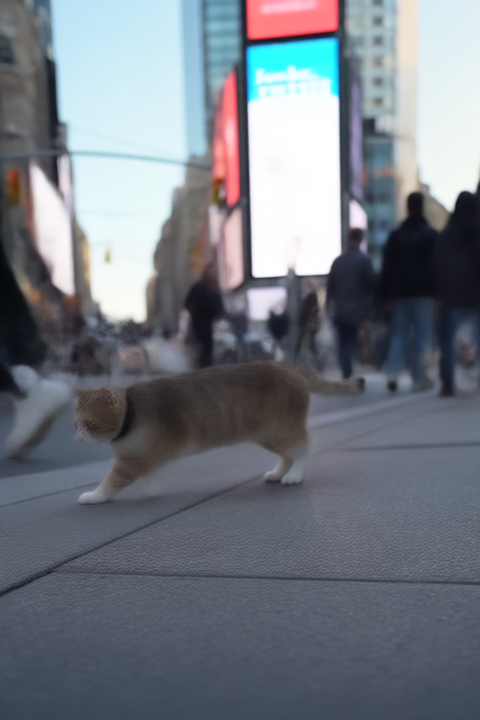

In [6]:
output[-1]

In [7]:
def export_to_video_bytes(fps, frames):
    with io.BytesIO() as buffer:
        writer = iio.get_writer(buffer, format='mp4', mode='I', fps=fps)
        for frame in frames:
            np_frame = np.array(frame)
            writer.append_data(np_frame)
        writer.close()
        video_bytes = buffer.getvalue()
    return video_bytes
    out_bytes = io.BytesIO(new_bytes)
    return out_bytes

def export_to_video(frames, path, fps):
    video_bytes = export_to_video_bytes(fps, frames)
    with open(path, "wb") as f:
        f.write(video_bytes)

In [8]:
export_to_video(output, "output5.mp4", fps=15)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
